# Data Preparation 1

This notebook consist in the first data preparation. PATIENTS, ADMISSIONS and ICUSTAYS files will be preprocessed. Then the creation of databases associated to intractable files directly with pandas DataFrames due to memory limitations (INPUTEVENTS_CV, LABEVENTS, NOTEEVENTS, CHARTEVENTS) is adressed. This approach is necessary because the use of SQL to query desired instances and put it in the form of pandas DataFrame will help to automate the process of feature extraction.

Files from MIMIC III used in this notebook:
- PATIENTS.csv       (processed directly as a pandas DataFrame)
- ADMISSIONS.csv     (processed directly as a pandas DataFrame)
- ICUSTAYS.csv       (processed directly as a pandas DataFrame)


- INPUTEVENTS_CV.csv (processed through database INPUTEVENTS_CV.db creation)
- LABEVENTS.csv      (processed through database LABEVENTS.db creation)
- NOTEEVENTS.csv     (processed through database NOTEEVENTS.db creation)
- CHARTEVENTS.csv    (processed through database CHARTEVENTS.db creation)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
import pylab
import sqlite3
matplotlib.style.use('ggplot')

### PATIENTS, ADMISSIONS and ICUSTAYS files preprocessing

#### PATIENTS

In [2]:
patients=pd.read_csv('data/PATIENTS.csv')
print(patients.shape)
print('unique SUBJECT_ID:', patients.SUBJECT_ID.nunique())
patients=patients.sort_values(by=['SUBJECT_ID'])
patients=patients.reset_index(drop=True)
patients.head()

(46520, 8)
unique SUBJECT_ID: 46520


,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,1,2,M,2138-07-17 00:00:00,NaN,NaN,NaN,0
1,2,3,M,2025-04-11 00:00:00,2102-06-14 00:00:00,NaN,2102-06-14 00:00:00,1
2,3,4,F,2143-05-12 00:00:00,NaN,NaN,NaN,0
3,4,5,M,2103-02-02 00:00:00,NaN,NaN,NaN,0
4,5,6,F,2109-06-21 00:00:00,NaN,NaN,NaN,0


In [3]:
patients.isnull().sum()

ROW_ID             0
SUBJECT_ID         0
GENDER             0
DOB                0
DOD            30761
DOD_HOSP       36546
DOD_SSN        33142
EXPIRE_FLAG        0
dtype: int64

Not interested in any date of death (DOD) nor EXPIRE_FLAG. We are interested in the HOSPITAL_EXPIRE_FLAG, nextly

In [4]:
patients=patients[['SUBJECT_ID', 'GENDER', 'DOB']]
patients.head()

,SUBJECT_ID,GENDER,DOB
0,2,M,2138-07-17 00:00:00
1,3,M,2025-04-11 00:00:00
2,4,F,2143-05-12 00:00:00
3,5,M,2103-02-02 00:00:00
4,6,F,2109-06-21 00:00:00


#### ADMISSIONS

In [5]:
admissions=pd.read_csv('data/ADMISSIONS.csv')
print(admissions.shape)
print('unique SUBJECT_ID:', admissions.SUBJECT_ID.nunique())
print('unique HADM_ID   :', admissions.HADM_ID.nunique())
admissions=admissions.sort_values(by=['SUBJECT_ID'])
admissions=admissions.reset_index(drop=True)
admissions.head()

(58976, 19)
unique SUBJECT_ID: 46520
unique HADM_ID   : 58976


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,NaN,ASIAN,NaN,NaN,NEWBORN,0,1
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1
2,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1
3,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,BUDDHIST,NaN,ASIAN,NaN,NaN,NEWBORN,0,1
4,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,CHRONIC RENAL FAILURE/SDA,0,1


In [6]:
admissions.isnull().sum()

ROW_ID                      0
SUBJECT_ID                  0
HADM_ID                     0
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               53122
ADMISSION_TYPE              0
ADMISSION_LOCATION          0
DISCHARGE_LOCATION          0
INSURANCE                   0
LANGUAGE                25332
RELIGION                  458
MARITAL_STATUS          10128
ETHNICITY                   0
EDREGTIME               28099
EDOUTTIME               28099
DIAGNOSIS                  25
HOSPITAL_EXPIRE_FLAG        0
HAS_CHARTEVENTS_DATA        0
dtype: int64

Drop not informative/important attributes. DEATHTIME is equal to DISCHTIME if HOSPITAL_EXPIRE_FLAG equals 1

In [7]:
admissions=admissions.drop(['ROW_ID', 'DEATHTIME',
                            'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'EDREGTIME', 'EDOUTTIME'], axis=1)

merge in a default inner manner patients with admissions

In [8]:
admissions=pd.merge(patients, admissions, on=['SUBJECT_ID'])
print(admissions.shape)
print('unique SUBJECT_ID:', admissions.SUBJECT_ID.nunique())
print('unique HADM_ID   :', admissions.HADM_ID.nunique())
admissions=admissions.sort_values(by=['SUBJECT_ID'])
admissions=admissions.reset_index(drop=True)
admissions.head()

(58976, 14)
unique SUBJECT_ID: 46520
unique HADM_ID   : 58976


,SUBJECT_ID,GENDER,DOB,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,2,M,2138-07-17 00:00:00,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,ASIAN,NEWBORN,0,1
1,3,M,2025-04-11 00:00:00,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,WHITE,HYPOTENSION,0,1
2,4,F,2143-05-12 00:00:00,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,WHITE,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1
3,5,M,2103-02-02 00:00:00,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,ASIAN,NEWBORN,0,1
4,6,F,2109-06-21 00:00:00,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,WHITE,CHRONIC RENAL FAILURE/SDA,0,1


#### ICUSTAYS

In [9]:
icustays=pd.read_csv('data/ICUSTAYS.csv')
print(icustays.shape)
print('unique SUBJECT_ID:', icustays.SUBJECT_ID.nunique())
print('unique HADM_ID   :', icustays.HADM_ID.nunique())
print('unique ICUSTAY_ID:', icustays.ICUSTAY_ID.nunique())
icustays=icustays.sort_values(by=['SUBJECT_ID'])
icustays=icustays.reset_index(drop=True)
icustays.head()

(61532, 12)
unique SUBJECT_ID: 46476
unique HADM_ID   : 57786
unique ICUSTAY_ID: 61532


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,1,2,163353,243653,carevue,NICU,NICU,56,56,2138-07-17 21:20:07,2138-07-17 23:32:21,0.0918
1,2,3,145834,211552,carevue,MICU,MICU,12,12,2101-10-20 19:10:11,2101-10-26 20:43:09,6.0646
2,3,4,185777,294638,carevue,MICU,MICU,52,52,2191-03-16 00:29:31,2191-03-17 16:46:31,1.6785
3,4,5,178980,214757,carevue,NICU,NICU,56,56,2103-02-02 06:04:24,2103-02-02 08:06:00,0.0844
4,5,6,107064,228232,carevue,SICU,SICU,33,33,2175-05-30 21:30:54,2175-06-03 13:39:54,3.6729


In [10]:
icustays=icustays.drop(['ROW_ID'], axis=1)

merge in a default inner manner admissions (patients+admissions) with icustays

In [11]:
admissions=pd.merge(admissions, icustays, on=['SUBJECT_ID', 'HADM_ID'])
print(admissions.shape)
print('unique SUBJECT_ID:', admissions.SUBJECT_ID.nunique())
print('unique HADM_ID   :', admissions.HADM_ID.nunique())
print('unique ICUSTAY_ID:', admissions.ICUSTAY_ID.nunique())
admissions=admissions.sort_values(by=['SUBJECT_ID'])
admissions=admissions.reset_index(drop=True)
admissions.head()

(61532, 23)
unique SUBJECT_ID: 46476
unique HADM_ID   : 57786
unique ICUSTAY_ID: 61532


,SUBJECT_ID,GENDER,DOB,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,HAS_CHARTEVENTS_DATA,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,2,M,2138-07-17 00:00:00,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,1,243653,carevue,NICU,NICU,56,56,2138-07-17 21:20:07,2138-07-17 23:32:21,0.0918
1,3,M,2025-04-11 00:00:00,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,1,211552,carevue,MICU,MICU,12,12,2101-10-20 19:10:11,2101-10-26 20:43:09,6.0646
2,4,F,2143-05-12 00:00:00,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,...,1,294638,carevue,MICU,MICU,52,52,2191-03-16 00:29:31,2191-03-17 16:46:31,1.6785
3,5,M,2103-02-02 00:00:00,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,1,214757,carevue,NICU,NICU,56,56,2103-02-02 06:04:24,2103-02-02 08:06:00,0.0844
4,6,F,2109-06-21 00:00:00,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,1,228232,carevue,SICU,SICU,33,33,2175-05-30 21:30:54,2175-06-03 13:39:54,3.6729


In [12]:
admissions['HAS_CHARTEVENTS_DATA'].value_counts()

1    61051
0      481
Name: HAS_CHARTEVENTS_DATA, dtype: int64

We drop admissions without chartevents data

In [13]:
admissions=admissions[admissions['HAS_CHARTEVENTS_DATA']==1]
admissions=admissions.drop(['HAS_CHARTEVENTS_DATA'], axis=1)
print(admissions.shape)
print('unique SUBJECT_ID:', admissions.SUBJECT_ID.nunique())
print('unique HADM_ID   :', admissions.HADM_ID.nunique())
print('unique ICUSTAY_ID   :', admissions.ICUSTAY_ID.nunique())

(61051, 22)
unique SUBJECT_ID: 46428
unique HADM_ID   : 57328
unique ICUSTAY_ID   : 61051


In [14]:
admissions.isnull().sum()

SUBJECT_ID               0
GENDER                   0
DOB                      0
HADM_ID                  0
ADMITTIME                0
DISCHTIME                0
ADMISSION_TYPE           0
ADMISSION_LOCATION       0
DISCHARGE_LOCATION       0
INSURANCE                0
ETHNICITY                0
DIAGNOSIS                1
HOSPITAL_EXPIRE_FLAG     0
ICUSTAY_ID               0
DBSOURCE                 0
FIRST_CAREUNIT           0
LAST_CAREUNIT            0
FIRST_WARDID             0
LAST_WARDID              0
INTIME                   0
OUTTIME                 10
LOS                     10
dtype: int64

Drop rows with at least one NaN in DIAGNOSIS, OUTTIME and LOS. DIAGNOSIS is important, LOS is the label (computed from OUTTIME and INTIME)

In [15]:
admissions=admissions.dropna(subset=['DIAGNOSIS', 'OUTTIME', 'LOS'])

In [16]:
admissions.isnull().sum()

SUBJECT_ID              0
GENDER                  0
DOB                     0
HADM_ID                 0
ADMITTIME               0
DISCHTIME               0
ADMISSION_TYPE          0
ADMISSION_LOCATION      0
DISCHARGE_LOCATION      0
INSURANCE               0
ETHNICITY               0
DIAGNOSIS               0
HOSPITAL_EXPIRE_FLAG    0
ICUSTAY_ID              0
DBSOURCE                0
FIRST_CAREUNIT          0
LAST_CAREUNIT           0
FIRST_WARDID            0
LAST_WARDID             0
INTIME                  0
OUTTIME                 0
LOS                     0
dtype: int64

Duration for each single HADM_ID. Duration for each single ICUSTAY_ID is the LOS

In [17]:
a=pd.to_datetime(admissions.DISCHTIME)-pd.to_datetime(admissions.ADMITTIME)
admissions['TIMEDELTA']=np.round(a.dt.total_seconds()/86400, 2)
admissions['TIMEDELTA_C']=np.where((admissions['TIMEDELTA']>0)&(admissions['TIMEDELTA']<3), '0-3',
                              np.where((admissions['TIMEDELTA']>=3)&(admissions['TIMEDELTA']<6), '3-6',
                                  np.where((admissions['TIMEDELTA']>=6)&(admissions['TIMEDELTA']<=10), '6-10','>10')))
admissions['LOS_C']=np.where((admissions['LOS']>0)&(admissions['LOS']<1), '0-1',
                              np.where((admissions['LOS']>=1)&(admissions['LOS']<2), '1-2',
                                  np.where((admissions['LOS']>=2)&(admissions['LOS']<4), '2-4','>4')))
print(admissions.shape)
admissions.head()

(61040, 25)


,SUBJECT_ID,GENDER,DOB,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS,TIMEDELTA,TIMEDELTA_C,LOS_C
0,2,M,2138-07-17 00:00:00,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,NICU,NICU,56,56,2138-07-17 21:20:07,2138-07-17 23:32:21,0.0918,3.86,3-6,0-1
1,3,M,2025-04-11 00:00:00,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,MICU,MICU,12,12,2101-10-20 19:10:11,2101-10-26 20:43:09,6.0646,10.78,>10,>4
2,4,F,2143-05-12 00:00:00,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,...,MICU,MICU,52,52,2191-03-16 00:29:31,2191-03-17 16:46:31,1.6785,7.76,6-10,1-2
3,5,M,2103-02-02 00:00:00,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,NICU,NICU,56,56,2103-02-02 06:04:24,2103-02-02 08:06:00,0.0844,2.32,0-3,0-1
4,6,F,2109-06-21 00:00:00,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,SICU,SICU,33,33,2175-05-30 21:30:54,2175-06-03 13:39:54,3.6729,16.36,>10,2-4


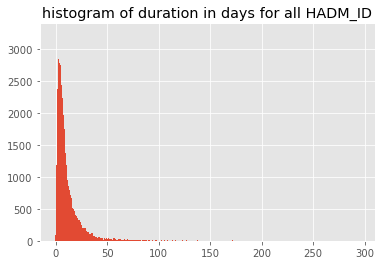

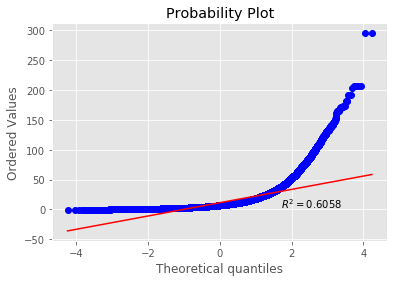

In [18]:
admissions['TIMEDELTA'].hist(bins=600)
plt.title('histogram of duration in days for all HADM_ID')
plt.show()
stats.probplot(admissions['TIMEDELTA'], dist="norm", plot=pylab, rvalue=True)
pylab.show()

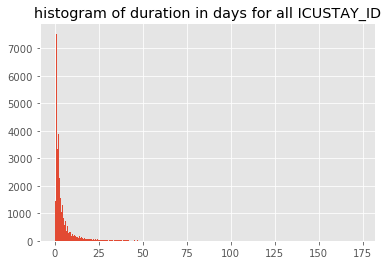

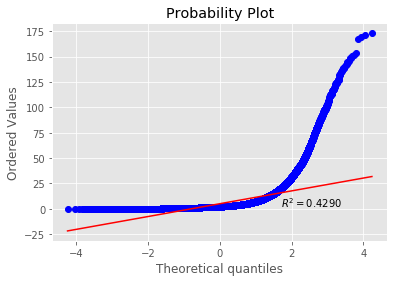

In [19]:
admissions['LOS'].hist(bins=600)
plt.title('histogram of duration in days for all ICUSTAY_ID')
plt.show()
stats.probplot(admissions['LOS'], dist="norm", plot=pylab, rvalue=True)
pylab.show()

Preserve coherence TIMEDELTA>0 and moderate TIMEDELTA (outlier removal)

Preserve coherence LOS>0 and moderate LOS (outlier removal)

In [20]:
admissions=admissions[np.abs(admissions['TIMEDELTA']-admissions['TIMEDELTA'].mean()) 
                      <= 2*admissions['TIMEDELTA'].std()]
admissions=admissions[np.abs(admissions['LOS']-admissions['LOS'].mean()) 
                      <= 2*admissions['LOS'].std()]
admissions=admissions[admissions['TIMEDELTA']>0]
admissions=admissions[admissions['LOS']>0]
print(admissions.shape)

(55518, 25)


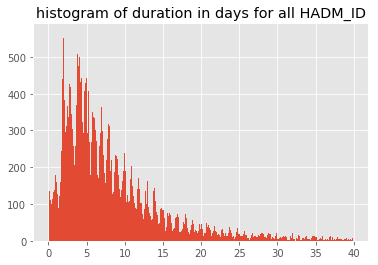

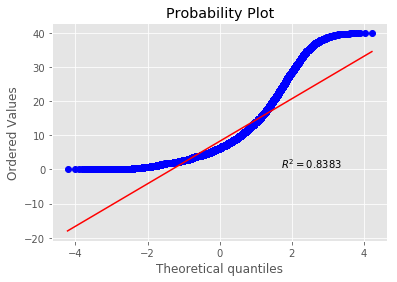

In [21]:
admissions['TIMEDELTA'].hist(bins=600)
plt.title('histogram of duration in days for all HADM_ID')
plt.show()
stats.probplot(admissions['TIMEDELTA'], dist="norm", plot=pylab, rvalue=True)
pylab.show()

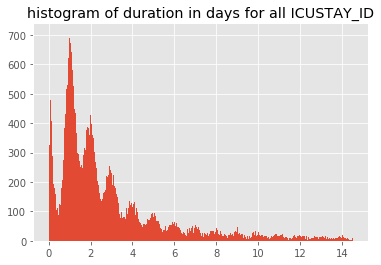

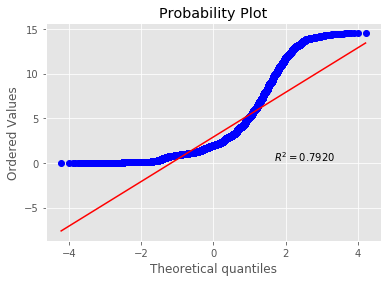

In [22]:
admissions['LOS'].hist(bins=600)
plt.title('histogram of duration in days for all ICUSTAY_ID')
plt.show()
stats.probplot(admissions['LOS'], dist="norm", plot=pylab, rvalue=True)
pylab.show()

we compute the age at the time the patient is admitted from date of birth DOB, then we drop DOB

In [23]:
age_h=pd.to_datetime(admissions.ADMITTIME)-pd.to_datetime(admissions.DOB)
admissions['AGE_AD']=np.round(age_h.dt.total_seconds()/31557600, 2)
admissions=admissions.drop(['DOB'], axis=1)

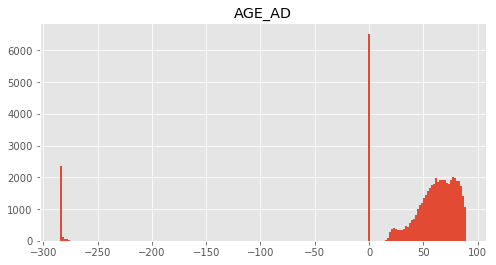

In [24]:
admissions.hist(column='AGE_AD', figsize=(8,4), bins=200)
plt.show()

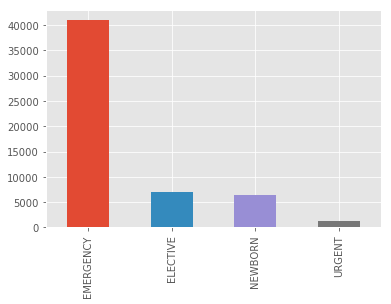

In [25]:
admissions['ADMISSION_TYPE'].value_counts().plot(kind='bar')
plt.show()

We have newborn admissions, they are not of our interest

In [26]:
admissions=admissions[admissions['ADMISSION_TYPE']!='NEWBORN']

In [27]:
admissions.shape

(49149, 25)

number admissions of patients older than 89 are negatively coded to preserve privacity (see MIMIC webpage)

In [28]:
older89=len(admissions[(admissions['AGE_AD']<0)])
older89

2617

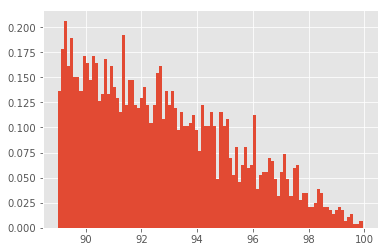

In [29]:
h=plt.hist(np.random.triangular(89.01, 89.01, 100, older89), bins=100, normed=True)
plt.show()

fill random triangular age to patients older than 89

not interested on patients younger than 16 

In [30]:
admissions['AGE_AD']=admissions['AGE_AD'].apply(lambda x: np.random.triangular(89.01, 89.01, 100) if x < 0 else x)
admissions=admissions[admissions['AGE_AD']>16]
admissions['AGE_C']=np.where((admissions['AGE_AD']>16)&(admissions['AGE_AD']<=40), '16-40',
                        np.where((admissions['AGE_AD']>40)&(admissions['AGE_AD']<=60), '40-60',
                            np.where((admissions['AGE_AD']>60)&(admissions['AGE_AD']<=80), '60-80', 'aged (>80)')))

(48989, 26)


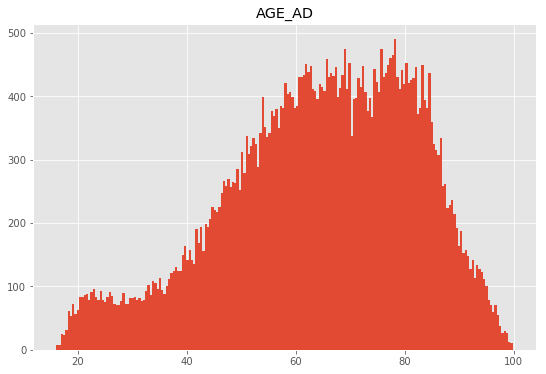

In [31]:
admissions.hist(column='AGE_AD', figsize=(9,6), bins=200)
print(admissions.shape)
plt.show()

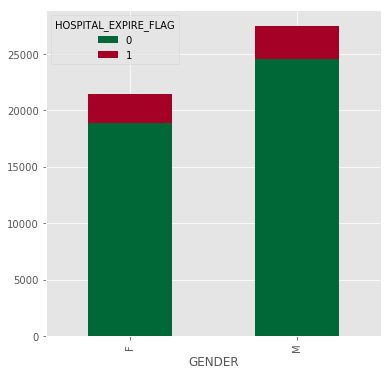

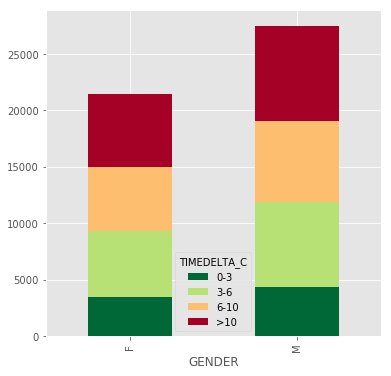

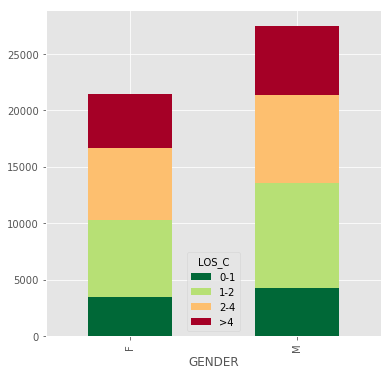

In [32]:
carat_table = pd.crosstab(index=admissions["GENDER"], 
                          columns=admissions["HOSPITAL_EXPIRE_FLAG"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()
carat_table = pd.crosstab(index=admissions["GENDER"], 
                          columns=admissions["TIMEDELTA_C"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()
carat_table = pd.crosstab(index=admissions["GENDER"], 
                          columns=admissions["LOS_C"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()

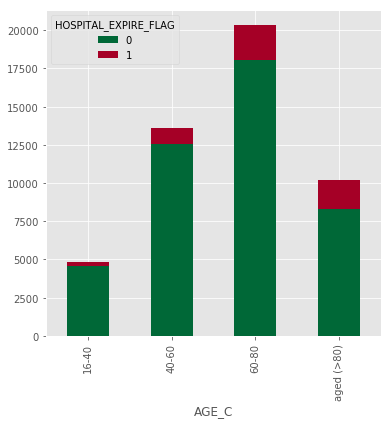

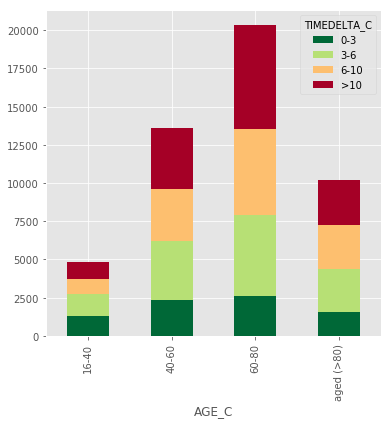

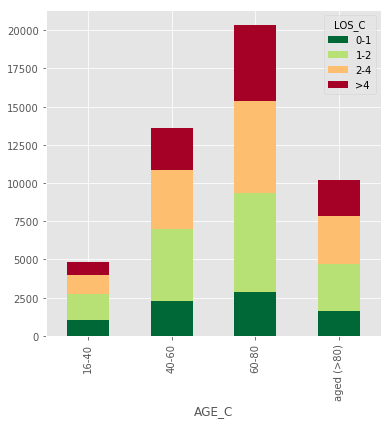

In [33]:
carat_table = pd.crosstab(index=admissions["AGE_C"], 
                          columns=admissions["HOSPITAL_EXPIRE_FLAG"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()
carat_table = pd.crosstab(index=admissions["AGE_C"], 
                          columns=admissions["TIMEDELTA_C"])
#carat_table=carat_table.reindex(["young", "20-60", "60-89", 'aged (>89)'])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()
carat_table = pd.crosstab(index=admissions["AGE_C"], 
                          columns=admissions["LOS_C"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()

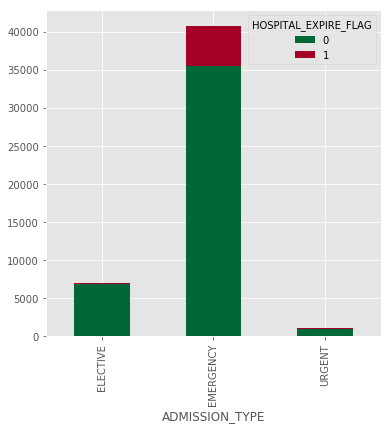

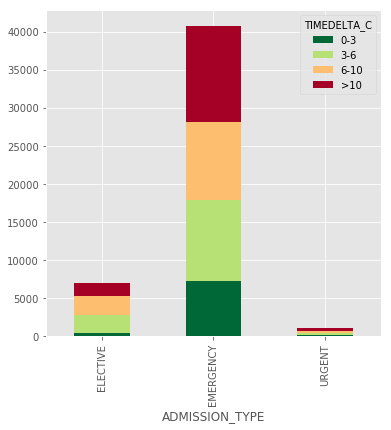

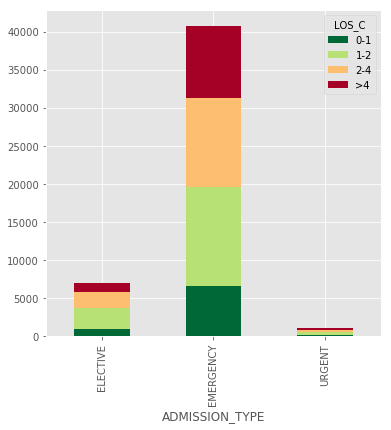

In [34]:
carat_table = pd.crosstab(index=admissions["ADMISSION_TYPE"], 
                          columns=admissions["HOSPITAL_EXPIRE_FLAG"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()
carat_table = pd.crosstab(index=admissions["ADMISSION_TYPE"], 
                          columns=admissions["TIMEDELTA_C"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()
carat_table = pd.crosstab(index=admissions["ADMISSION_TYPE"], 
                          columns=admissions["LOS_C"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()

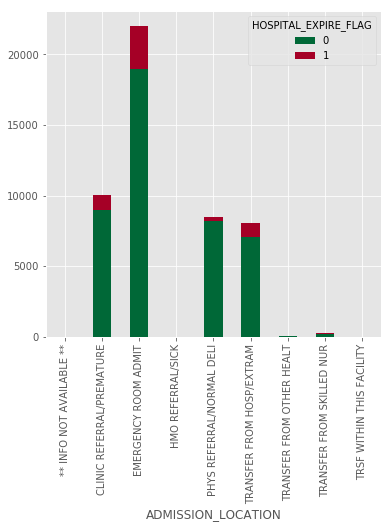

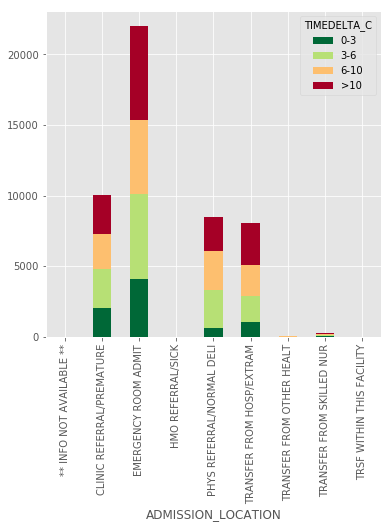

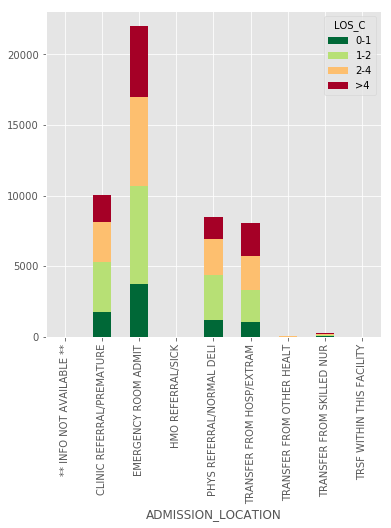

In [35]:
carat_table = pd.crosstab(index=admissions["ADMISSION_LOCATION"], 
                          columns=admissions["HOSPITAL_EXPIRE_FLAG"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()
carat_table = pd.crosstab(index=admissions["ADMISSION_LOCATION"], 
                          columns=admissions["TIMEDELTA_C"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()
carat_table = pd.crosstab(index=admissions["ADMISSION_LOCATION"], 
                          columns=admissions["LOS_C"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()

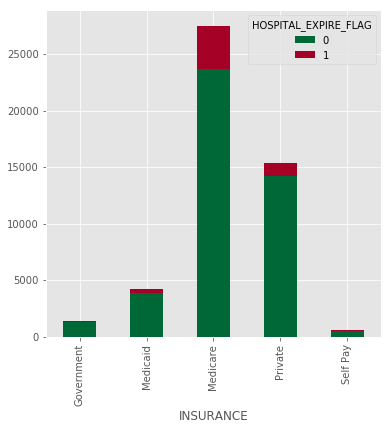

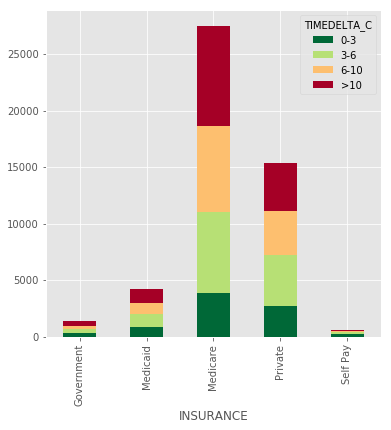

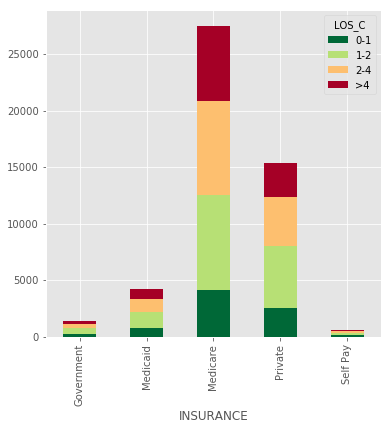

In [36]:
carat_table = pd.crosstab(index=admissions["INSURANCE"], 
                          columns=admissions["HOSPITAL_EXPIRE_FLAG"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()
carat_table = pd.crosstab(index=admissions["INSURANCE"], 
                          columns=admissions["TIMEDELTA_C"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()
carat_table = pd.crosstab(index=admissions["INSURANCE"], 
                          columns=admissions["LOS_C"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()

In [37]:
admissions.ETHNICITY[admissions.ETHNICITY != 'WHITE'] = 'NW'

/home/jordi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


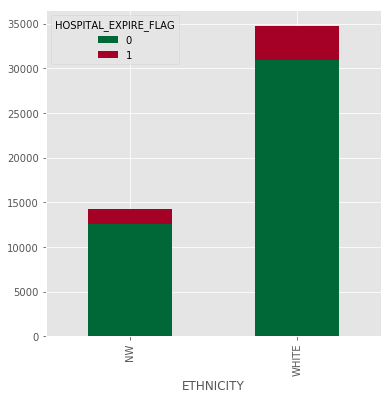

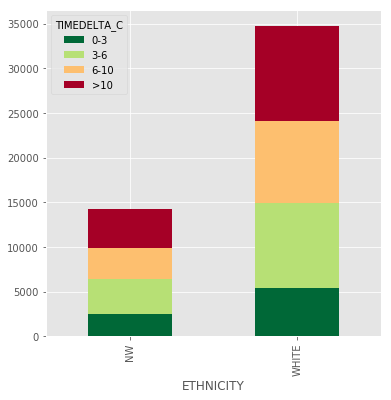

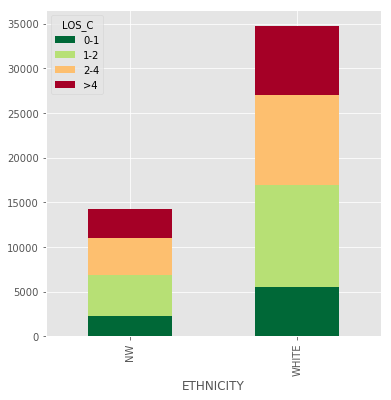

In [38]:
carat_table = pd.crosstab(index=admissions["ETHNICITY"], 
                          columns=admissions["HOSPITAL_EXPIRE_FLAG"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()
carat_table = pd.crosstab(index=admissions["ETHNICITY"], 
                          columns=admissions["TIMEDELTA_C"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()
carat_table = pd.crosstab(index=admissions["ETHNICITY"], 
                          columns=admissions["LOS_C"])
carat_table.plot(kind="bar", figsize=(6,6), stacked=True, colormap='RdYlGn_r')
plt.show()

In [39]:
admissions=admissions.drop(['AGE_C'], axis=1)
print(admissions.shape)
print('unique SUBJECT_ID:', admissions.SUBJECT_ID.nunique())
print('unique HADM_ID:   ', admissions.HADM_ID.nunique())
print('unique ICUSTAY_ID:', admissions.ICUSTAY_ID.nunique())
admissions=admissions.sort_values(by=['SUBJECT_ID'])
admissions=admissions.reset_index(drop=True)
admissions.head()

(48989, 25)
unique SUBJECT_ID: 36659
unique HADM_ID:    46273
unique ICUSTAY_ID: 48989


,SUBJECT_ID,GENDER,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,ETHNICITY,...,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS,TIMEDELTA,TIMEDELTA_C,LOS_C,AGE_AD
0,3,M,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,WHITE,...,MICU,12,12,2101-10-20 19:10:11,2101-10-26 20:43:09,6.0646,10.78,>10,>4,76.53
1,4,F,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,WHITE,...,MICU,52,52,2191-03-16 00:29:31,2191-03-17 16:46:31,1.6785,7.76,6-10,1-2,47.84
2,6,F,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,WHITE,...,SICU,33,33,2175-05-30 21:30:54,2175-06-03 13:39:54,3.6729,16.36,>10,2-4,65.94
3,9,M,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,NW,...,MICU,15,15,2149-11-09 13:07:02,2149-11-14 20:52:14,5.3231,4.88,3-6,>4,41.79
4,11,F,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,WHITE,...,SICU,57,57,2178-04-16 06:19:32,2178-04-17 20:21:05,1.5844,25.53,>10,1-2,50.15


In [40]:
admissions.HOSPITAL_EXPIRE_FLAG.value_counts()

0    43416
1     5573
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64

In [41]:
admissions.isnull().sum()

SUBJECT_ID              0
GENDER                  0
HADM_ID                 0
ADMITTIME               0
DISCHTIME               0
ADMISSION_TYPE          0
ADMISSION_LOCATION      0
DISCHARGE_LOCATION      0
INSURANCE               0
ETHNICITY               0
DIAGNOSIS               0
HOSPITAL_EXPIRE_FLAG    0
ICUSTAY_ID              0
DBSOURCE                0
FIRST_CAREUNIT          0
LAST_CAREUNIT           0
FIRST_WARDID            0
LAST_WARDID             0
INTIME                  0
OUTTIME                 0
LOS                     0
TIMEDELTA               0
TIMEDELTA_C             0
LOS_C                   0
AGE_AD                  0
dtype: int64

In [42]:
admissions.columns

Index(['SUBJECT_ID', 'GENDER', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION',
       'INSURANCE', 'ETHNICITY', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG',
       'ICUSTAY_ID', 'DBSOURCE', 'FIRST_CAREUNIT', 'LAST_CAREUNIT',
       'FIRST_WARDID', 'LAST_WARDID', 'INTIME', 'OUTTIME', 'LOS', 'TIMEDELTA',
       'TIMEDELTA_C', 'LOS_C', 'AGE_AD'],
      dtype='object')

In [43]:
admissions=admissions[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'GENDER', 'AGE_AD', 'ADMITTIME',
       'DISCHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'ETHNICITY', 
       'DIAGNOSIS', 'DBSOURCE', 'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID', 'INTIME', 'OUTTIME', 
       'LOS', 'LOS_C', 'TIMEDELTA', 'TIMEDELTA_C', 'HOSPITAL_EXPIRE_FLAG']]

From the original 58976 unique HADM_ID and 61532 unique ICUSTAY_ID associated to a total of 46520 different SUBJECT_ID, we have now 46273 unique HADM_ID and 48989 unique ICUSTAY_ID associated to a total of 36659 different SUBJECT_ID. Note that ICUSTAY_ID is a good candidate to identify each single row

We have patients with a single hospital admission and patients with several hospital admissions (same to icu admissions ICUSTAY_ID)

In [44]:
admissions[admissions['SUBJECT_ID']==3]

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,GENDER,AGE_AD,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,...,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS,LOS_C,TIMEDELTA,TIMEDELTA_C,HOSPITAL_EXPIRE_FLAG
0,3,145834,211552,M,76.53,2101-10-20 19:08:00,2101-10-31 13:58:00,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,...,MICU,12,12,2101-10-20 19:10:11,2101-10-26 20:43:09,6.0646,>4,10.78,>10,0


In [45]:
admissions[admissions['SUBJECT_ID']==17]

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,GENDER,AGE_AD,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,...,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS,LOS_C,TIMEDELTA,TIMEDELTA_C,HOSPITAL_EXPIRE_FLAG
7,17,161087,257980,F,47.82,2135-05-09 14:11:00,2135-05-13 14:40:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,...,CSRU,12,12,2135-05-09 14:12:06,2135-05-10 11:18:34,0.8795,0-1,4.02,3-6,0
8,17,194023,277042,F,47.45,2134-12-27 07:15:00,2134-12-31 16:05:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,...,CSRU,12,12,2134-12-27 16:21:48,2134-12-29 18:04:03,2.0710,2-4,4.37,3-6,0


At the end we are interested in each single case (row with ICUSTAY_ID identification)

Export the table as a csv file. This file will be the basis in order to aggregate features

In [46]:
admissions.to_csv('MAIN_DF.csv')

# DATABASE CREATIONS

### INPUTEVENTS_CV_DB Database creation from INPUTEVENTS_CV.csv

In [29]:
connex = sqlite3.connect("data/INPUTEVENTS_CV.db")

In [31]:
for chunk in pd.read_csv('data/INPUTEVENTS_CV.csv', chunksize=1000000):
    chunk.to_sql(name="INPUTEVENTS_CV_DB", con=connex, if_exists="append", index=False)

/home/jordi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jordi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jordi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jordi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7,9,17,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, co

### LABEVENTS_DB Database creation from LABEVENTS.csv

In [32]:
connex = sqlite3.connect("data/LABEVENTS.db")

In [34]:
for chunk in pd.read_csv('data/LABEVENTS.csv', chunksize=1000000):
    chunk.to_sql(name="LABEVENTS_DB", con=connex, if_exists="append", index=False)

### NOTEEVENTS_DB Database creation from NOTEEVENTS.csv

In [41]:
connex = sqlite3.connect("data/NOTEEVENTS.db")

In [36]:
for chunk in pd.read_csv('data/NOTEEVENTS.csv', chunksize=1000000):
    chunk.to_sql(name="NOTEEVENTS_DB", con=connex, if_exists="append", index=False)

/home/jordi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jordi/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### CHARTEVENTS_DB Database creation from CHARTEVENTS.csv

In [111]:
connex = sqlite3.connect("data/CHARTEVENTS.db")

In [23]:
for chunk in pd.read_csv('data/CHARTEVENTS.csv', chunksize=1000000):
    chunk.to_sql(name="CHARTEVENTS_DB", con=connex, if_exists="append", index=False)

### Example of data extraction from SUBJECT_ID nº 34 from CHARTEVENTS_DB
From CHARTEVENTS_DB to a pandas DataFrame

In [128]:
connex = sqlite3.connect("data/CHARTEVENTS.db")

In [129]:
cur = connex.cursor()

In [130]:
ids = [34]
ids = [str(id) for id in ids] 
str_matching = "(" + ",".join(ids) + ")"  # Construct the string of SQL
print(str_matching)

(34)


In [131]:
#sql = "SELECT DISTINCT SUBJECT_ID FROM CHARTEVENTS_DB;"
sql = "SELECT * FROM CHARTEVENTS_DB WHERE SUBJECT_ID IN " + str_matching + ";"
print('String of SQL   :', sql)
print('Object Execution:', cur.execute(sql))

String of SQL   : SELECT * FROM CHARTEVENTS_DB WHERE SUBJECT_ID IN (34);
Object Execution: <sqlite3.Cursor object at 0x7f3f1fe50ce0>


In [132]:
df = pd.read_sql_query(sql, connex)
print(type(df))
print(df.shape)
df.head()

<class 'pandas.core.frame.DataFrame'>
(2498, 15)


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,326,34,144319,290505.0,220180,2191-02-23 05:30:00,2191-02-23 07:45:00,17741.0,66,66.0,mmHg,0.0,0.0,None,None
1,327,34,144319,290505.0,220181,2191-02-23 05:30:00,2191-02-23 07:45:00,17741.0,78,78.0,mmHg,0.0,0.0,None,None
2,328,34,144319,290505.0,223875,2191-02-23 07:00:00,2191-02-23 07:36:00,16924.0,10,10.0,insp/min,0.0,0.0,None,None
3,329,34,144319,290505.0,224690,2191-02-23 07:00:00,2191-02-23 07:35:00,16924.0,22,22.0,insp/min,0.0,0.0,None,None
4,330,34,144319,290505.0,224696,2191-02-23 07:00:00,2191-02-23 07:35:00,16924.0,16,16.0,cmH2O,0.0,0.0,None,None


The use of SQL through sqlite3 library will help to automate the feature extraction process